In [1]:
import numpy as np
from sdm_ml.dataset import BBSDataset
from sklearn.preprocessing import StandardScaler
from kernels import ard_rbf_kernel
import matplotlib.pyplot as plt
%matplotlib inline
from sksparse.cholmod import cholesky
import scipy.sparse as sps
from scipy.special import expit

In [2]:
csv_folder = '../../../multi_species/bbs/dataset/csv_bird_data/'
dataset = BBSDataset(csv_folder)

In [3]:
training_set = dataset.get_training_set()

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

covariates = scaler.fit_transform(training_set['covariates'].values)
outcomes = training_set['outcomes'][['American Crow', 'Brown-headed Cowbird']]

scaler = StandardScaler()

# Keep only the first 200 rows and 2 outcomes for this test
covariates = scaler.fit_transform(covariates.astype(np.float32))[:400, :]
outcomes = outcomes.values[:400, :2]

y_flat = np.reshape(outcomes[:, 0], (-1), order='F').astype(float)

/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


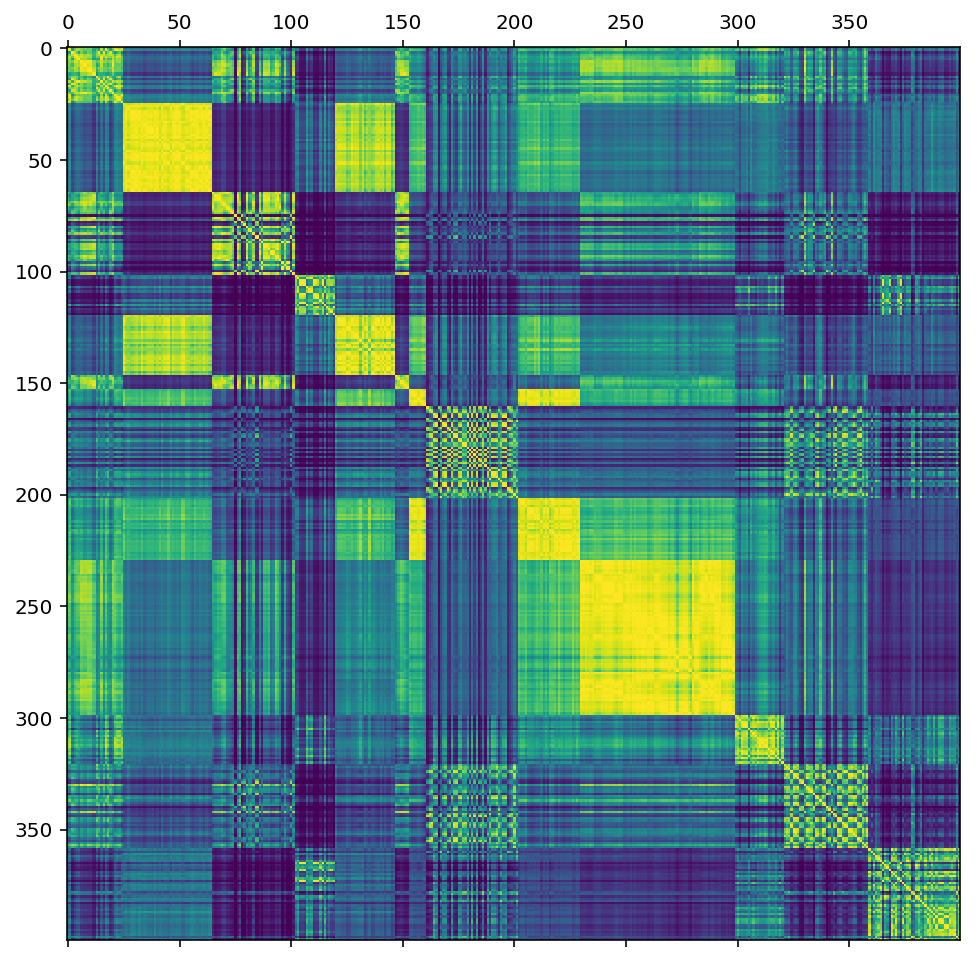

In [5]:
K1, l1_grad, s1_grad = ard_rbf_kernel(covariates, covariates, np.linspace(2, 4, 8), 1., jitter=1e-5)
K = sps.csc_matrix(K1)

plt.matshow(K.todense())
plt.gcf().set_size_inches(8, 8)

In [6]:
l1_grad.shape

(400, 400, 8)

In [7]:
# Try to follow R & W to the letter

In [8]:
def find_mode(K, y):
    
    f = np.zeros(K.shape[0])
    old_f = np.ones_like(f)
    
    while np.sum((f - old_f)**2) > 1e-8:

        probs = expit(f)
        grad_log_y = y_flat - probs

        W = sps.csc_matrix(np.diag(probs * (1 - probs)))
        W_sqrt = np.sqrt(W)
        multiplied = W_sqrt.dot(K).dot(W_sqrt)

        B = multiplied + sps.eye(K.shape[0], format='csc')
        L = cholesky(B)
        b = W.dot(f) + grad_log_y

        first_solve = L.solve_L(W_sqrt.dot(K.dot(b)), False)
        second_solve = L.solve_Lt(first_solve, False)

        a = b - W_sqrt.dot(second_solve)
        old_f = f
        f = K.dot(a)
        
    # Calculate the log marginal likelihood
    log_lik = np.sum(y * f - np.log1p(np.exp(f)))
    log_marg_lik = -0.5 * a.T.dot(f) + log_lik - np.log(L.L().diagonal()).sum()

    return f, log_marg_lik

In [9]:
s1_grad.shape

(400, 400)

In [10]:
def log_marg_lik_and_grad(hyperparams):
    
    lengthscales = hyperparams[:-1]
    variance = hyperparams[-1]

    K1, l1_grad, s1_grad = ard_rbf_kernel(covariates, covariates, lengthscales, 
                                          variance, jitter=1e-5)
    
    K = sps.csc_matrix(K1)
    
    all_grads = np.concatenate([l1_grad, np.expand_dims(s1_grad, axis=2)], axis=2)

    f, Z = find_mode(K, y_flat)

    probs = expit(f)

    grad_log_y = y_flat - probs
    third_grad = expit(f) - 3 * expit(f)**2 + 2 * expit(f)**3

    W = sps.csc_matrix(np.diag(probs * (1 - probs)))
    W_sqrt = np.sqrt(W)
    multiplied = W_sqrt.dot(K).dot(W_sqrt)

    B = multiplied + sps.eye(K.shape[0], format='csc')

    L = cholesky(B)
    b = W.dot(f) + grad_log_y

    first_solve = L.solve_L(W_sqrt.dot(K.dot(b)), False)
    second_solve = L.solve_Lt(first_solve, False)
    a = b - W_sqrt.dot(second_solve)

    R = W_sqrt.dot(L.solve_Lt(L.solve_L(W_sqrt, False), False))
    C = L.solve_L(W_sqrt.dot(K), False)

    diag_diff = sps.csc_matrix(np.diag(K.diagonal() - C.transpose().dot(C).diagonal()))
    s2 = -0.5 * diag_diff.dot(third_grad)

    grads = list()

    for cur_grad in range(all_grads.shape[2]):

        C = all_grads[:, :, cur_grad]
        s1 = 0.5 * a.T.dot(C).dot(a) - 0.5 * np.sum(R.dot(C).diagonal())
        b = C.dot(grad_log_y)
        s3 = b - K.dot((R.dot(b)))
        grads.append(s1 + s2.T.dot(s3))
        
    print(Z)
    print(np.array(grads))
        
    return Z, np.array(grads)

In [11]:
log_marg_lik_and_grad(np.concatenate([np.linspace(2, 4, 8), [1.]]))[1]

-159.06059449123026
[-1.29615438e+00 -1.32980499e-01 -2.42659131e+00 -2.05242693e-02
  5.36922005e-01 -1.15161475e+00 -7.33032675e-01 -1.34598788e+00
  3.50641525e+01]


array([-1.29615438e+00, -1.32980499e-01, -2.42659131e+00, -2.05242693e-02,
        5.36922005e-01, -1.15161475e+00, -7.33032675e-01, -1.34598788e+00,
        3.50641525e+01])

In [12]:
from scipy.optimize import fmin_cg

In [13]:
to_minimise = lambda x: -log_marg_lik_and_grad(x)[0]
grads = lambda x: -log_marg_lik_and_grad(x)[1]

In [14]:
fmin_cg(to_minimise, x0=np.concatenate([np.linspace(2, 4, 8), [1.]]), fprime=grads, gtol=1e-2)

-159.06059449123026
[-1.29615438e+00 -1.32980499e-01 -2.42659131e+00 -2.05242693e-02
  5.36922005e-01 -1.15161475e+00 -7.33032675e-01 -1.34598788e+00
  3.50641525e+01]
-159.06059449123026
[-1.29615438e+00 -1.32980499e-01 -2.42659131e+00 -2.05242693e-02
  5.36922005e-01 -1.15161475e+00 -7.33032675e-01 -1.34598788e+00
  3.50641525e+01]
-141.91021284611446
[-0.47267749 -0.1775693  -1.29214897 -0.02063305  0.06854132 -0.61006376
 -0.16877027 -0.88785008  6.97528251]
-141.91021284611446
[-0.47267749 -0.1775693  -1.29214897 -0.02063305  0.06854132 -0.61006376
 -0.16877027 -0.88785008  6.97528251]
-140.44172735314706
[ 0.91380839 -1.72911927  1.84991054  0.43831844 -0.01458232 -0.28730374
  1.21718151 -0.36840883 -1.40073678]
-140.44172735314706
[ 0.91380839 -1.72911927  1.84991054  0.43831844 -0.01458232 -0.28730374
  1.21718151 -0.36840883 -1.40073678]
-138.8339832912545
[-0.00785727  0.43252911 -0.11926479  0.72714355 -0.24139079 -0.28588778
  0.57658619 -0.15910548 -1.20824305]
-138.83398

-134.33323154780345
[-0.01923093 -0.00607036 -0.00100222 -0.00804168 -0.0139106  -0.01547559
  0.03063468 -0.02254727  0.02108744]
-134.33178718634113
[ 0.00653408  0.04507767  0.03028959 -0.00992057  0.01727422 -0.01329596
  0.03175105  0.0126523  -0.00983985]
-134.33178718634113
[ 0.00653408  0.04507767  0.03028959 -0.00992057  0.01727422 -0.01329596
  0.03175105  0.0126523  -0.00983985]
-134.3298981287183
[ 0.00707226 -0.03512468  0.02286142 -0.00983925  0.03018857 -0.00497349
  0.03373478  0.02454561 -0.01791703]
-134.3298981287183
[ 0.00707226 -0.03512468  0.02286142 -0.00983925  0.03018857 -0.00497349
  0.03373478  0.02454561 -0.01791703]
-134.3275431243456
[-0.01422111  0.02181556 -0.04483451 -0.00464404  0.00367814 -0.00110514
  0.02840379  0.01298417  0.00024424]
-134.3275431243456
[-0.01422111  0.02181556 -0.04483451 -0.00464404  0.00367814 -0.00110514
  0.02840379  0.01298417  0.00024424]
-134.324052555003
[-0.0162677  -0.03095955 -0.0174475   0.00338961 -0.0092787   0.00545

array([1.75409411, 1.33457764, 1.95660382, 3.31403975, 1.79947486,
       2.09700364, 7.53907322, 1.63606793, 3.87917239])